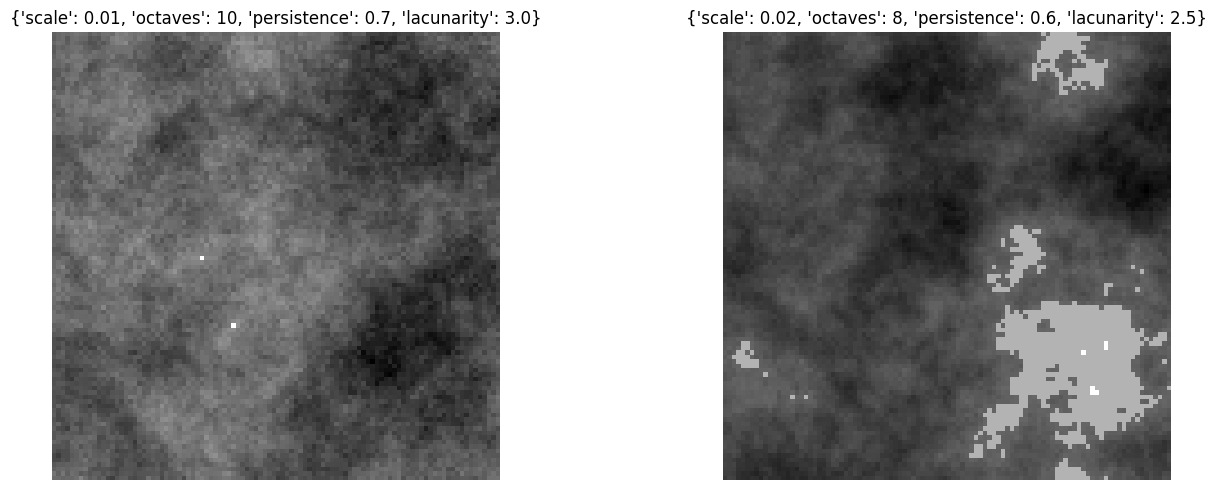

In [31]:
import torch
import noise
import numpy as np
import matplotlib.pyplot as plt

def generate_grid(width, height, scale=0.1, octaves=6, persistence=0.5, lacunarity=2.0):
    """Generate a 2D grid with obstacles using simplex noise."""
    
    # Create an empty grid
    grid = np.empty((height, width))
    
    # Populate the grid with noise values
    for x in range(width):
        for y in range(height):
            # Generate simplex noise
            n = noise.pnoise2(x*scale, y*scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
            
            # Convert noise value to [0, 1]
            n = (n + 1) / 2
            
            # Create a halo effect for larger clusters
            if n > 0.7:
                n = 1
            elif n > 0.6:
                n = 0.8
                
            grid[y, x] = n
    
    return grid

# Define different parameter combinations
params = [
    {"scale": 0.01, "octaves": 10, "persistence": 0.7, "lacunarity": 3.0},  # More fractal-like
    {"scale": 0.02, "octaves": 8, "persistence": 0.6, "lacunarity": 2.5},  # More fractal-like
    # {"scale": 0.1, "octaves": 6, "persistence": 0.5, "lacunarity": 2.0}, too small
    # {"scale": 0.05, "octaves": 3, "persistence": 0.4, "lacunarity": 1.5}, a bit bigger
    # Add more parameter combinations as desired
]

fig, axes = plt.subplots(nrows=1, ncols=len(params), figsize=(15, 5))

# For each parameter set, generate and visualize the grid
for i, p in enumerate(params):
    grid = generate_grid(100, 100, **p)
    axes[i].imshow(grid, cmap="gray")
    axes[i].set_title(str(p))
    axes[i].axis("off")

plt.tight_layout()
plt.show()


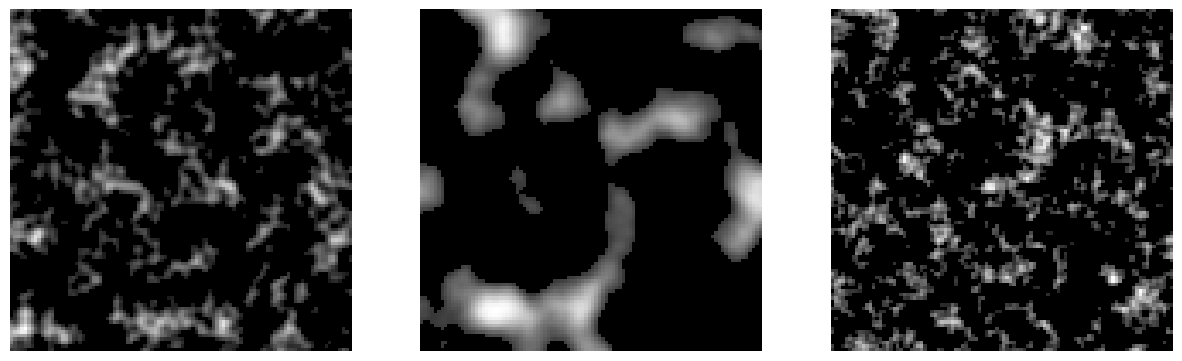

In [59]:
import random
config = {
    "environment": {
        "obstacle_generation": "perlin_noise",
        "obstacle_generation_params": {
            "empty_threshold": [0.05, 0.1],
            "full_threshold": [0.8, 0.9],
            "frequency": [4.0, 30.0],
            "octaves": [1, 10],
            "persistence": [0.2, 1.0],
            "lacunarity": [1.5, 4.0]
        }
    }
}
def populate_obstacle(config, channel):
    obstacle_params = config["environment"]["obstacle_generation_params"]
    
    if config["environment"]["obstacle_generation"] == "perlin_noise":
        empty_threshold = obstacle_params.get("empty_threshold", [0.05, 0.1])
        full_threshold = obstacle_params.get("full_threshold", [0.8, 0.9])
        frequency_range = obstacle_params.get("frequency", [4.0, 16.0])
        octaves_range = obstacle_params.get("octaves", [1, 4])
        persistence_range = obstacle_params.get("persistence", [0.25, 1.0])
        lacunarity_range = obstacle_params.get("lacunarity", [1.5, 3.0])

        empty_threshold = random.uniform(*empty_threshold)
        full_threshold = random.uniform(*full_threshold)
        frequency = random.uniform(*frequency_range)
        octaves = random.randint(*octaves_range)
        persistence = random.uniform(*persistence_range)
        lacunarity = random.uniform(*lacunarity_range)

        # Generate random offsets for x and y
        x_offset = random.randint(0, 10000)
        y_offset = random.randint(0, 10000)

        for x in range(channel.shape[0]):
            for y in range(channel.shape[1]):
                value = noise.pnoise2((x + x_offset) / frequency, (y + y_offset) / frequency, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
                channel[x, y] = 1 if value > full_threshold else 0 if value < empty_threshold else value
    else:
        raise ValueError(f"Obstacle generation method {config['environment']['obstacle_generation']} not recognized.")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# visualize 4 random obstacle maps
for i in range(3):
    channel = np.zeros((100, 100))
    populate_obstacle(config, channel)
    axes[i].imshow(channel, cmap="gray")
    axes[i].axis("off")

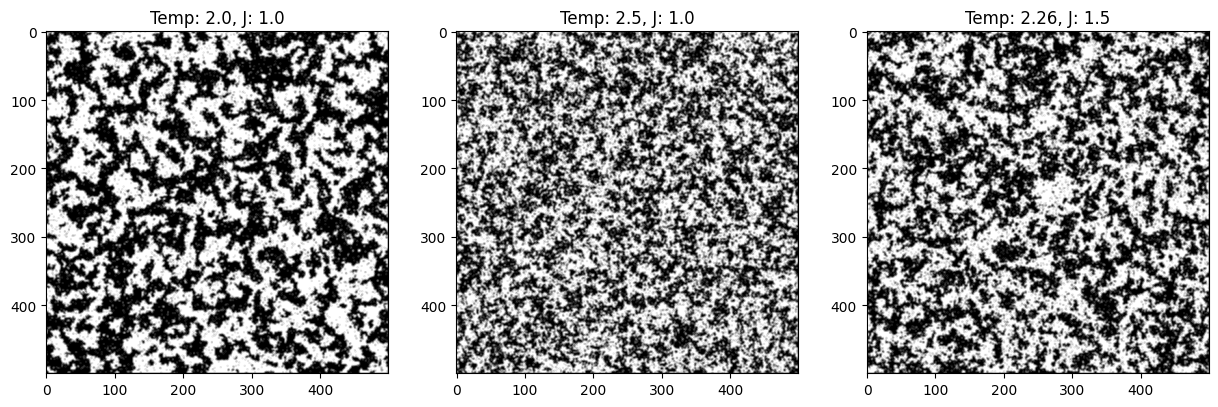

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_obstacles(width, height, noise_params=None):
    if noise_params is None:
        noise_params = {'temp': 2.26, 'j': 1.0}  # Default values for 2D Ising

    # Create a random matrix
    lattice = torch.randint(2, (width, height), dtype=torch.float32) * 2 - 1

    # Ising model update (Metropolis algorithm for a few iterations)
    for _ in range(10):
        for x in range(width):
            for y in range(height):
                deltaE = 2 * lattice[x, y] * (lattice[(x+1) % width, y] + lattice[x-1, y] + lattice[x, (y+1) % height] + lattice[x, y-1])
                if deltaE < 0 or torch.rand(1) < torch.exp(-deltaE / noise_params['temp']):
                    lattice[x, y] *= -1

    # Normalize to [0, 1]
    lattice = (lattice + 1) / 2

    # Apply filter for boundaries
    filter_kernel = torch.tensor([[0.5, 1, 0.5], [1, 0, 1], [0.5, 1, 0.5]])
    lattice = torch.nn.functional.conv2d(lattice.unsqueeze(0).unsqueeze(0), filter_kernel.unsqueeze(0).unsqueeze(0), padding=1).squeeze()

    return lattice.numpy()

# Test Cases
param_sets = [
    {'temp': 2.0, 'j': 1.0},
    {'temp': 2.5, 'j': 1.0},
    {'temp': 2.26, 'j': 1.5},
]

fig, axes = plt.subplots(1, len(param_sets), figsize=(15, 5))

for ax, params in zip(axes, param_sets):
    obstacles = generate_obstacles(100, 100, noise_params=params)
    ax.imshow(obstacles, cmap="gray")
    ax.set_title(f"Temp: {params['temp']}, J: {params['j']}")

plt.show()
